YOLOS for Fashion
====


In [1]:
from PIL import Image
import supervision as sv
import matplotlib.pyplot as plt
import torch
from transformers import YolosFeatureExtractor, YolosForObjectDetection


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor = YolosFeatureExtractor.from_pretrained(
    'hustvl/yolos-small'
)
model = YolosForObjectDetection.from_pretrained(
    "valentinafeve/yolos-fashionpedia"
).eval().to(device);


In [12]:
CATS = [
    'shirt, blouse', 'top, t-shirt, sweatshirt',
    'sweater', 'cardigan', 'jacket', 'vest', 'pants',
    'shorts', 'skirt', 'coat', 'dress', 'jumpsuit',
    'cape', 'glasses', 'hat',
    'headband, head covering, hair accessory',
    'tie', 'glove', 'watch', 'belt', 'leg warmer',
    'tights, stockings', 'sock', 'shoe', 'bag, wallet',
    'scarf', 'umbrella', 'hood', 'collar', 'lapel',
    'epaulette', 'sleeve', 'pocket', 'neckline',
    'buckle', 'zipper', 'applique', 'bead', 'bow',
    'flower', 'fringe', 'ribbon', 'rivet', 'ruffle',
    'sequin', 'tassel'
]

In [20]:
image_path = "../samples/person.jpg"

image = Image.open(image_path).convert("RGB")
image = image.resize((600, 800))


inputs = feature_extractor(images=image, return_tensors="pt")
inputs = inputs.to(device)

with torch.no_grad():
    outputs = model(**inputs)

outputs.logits.shape, outputs.pred_boxes.shape

(torch.Size([1, 100, 47]), torch.Size([1, 100, 4]))

In [14]:
import torch.nn.functional as F

probas = F.softmax(outputs.logits, dim=-1)
probs_wout_bg = probas[..., :-1]
print(probas.shape, probs_wout_bg.shape)

scores, labels = probs_wout_bg.max(dim=-1)

# filter low-confidence predictions
keep = scores[0] > 0.6
filtered_boxes = outputs.pred_boxes[0][keep]
filtered_scores = scores[0][keep]
filtered_labels = labels[0][keep]

print(
    filtered_boxes.shape,
    filtered_scores.shape,
    filtered_labels.shape
)

# print the predicted classes:
for score, label in zip(filtered_scores, filtered_labels):
    print(
        f"Detected {CATS[label.item()]} with confidence "
        f"{score.item():.3f}"
    )

torch.Size([1, 100, 47]) torch.Size([1, 100, 46])
torch.Size([7, 4]) torch.Size([7]) torch.Size([7])
Detected collar with confidence 0.952
Detected lapel with confidence 0.662
Detected jacket with confidence 0.694
Detected sleeve with confidence 0.980
Detected shirt, blouse with confidence 0.671
Detected sleeve with confidence 0.990
Detected pocket with confidence 0.803


In [28]:
import numpy as np
import torchvision

def visualize_bboxes(image, predictions, show_scores=True):
    bboxes = predictions["boxes"]
    labels = predictions["labels"]
    scores = predictions["scores"]
    uniq_labels = np.unique(labels)
    # map labels to class ids
    class_map = {label: i for i, label in enumerate(uniq_labels)}
    print(class_map)

    print("bboxes:", bboxes.shape)
    detections = sv.Detections(
        xyxy=bboxes,
        class_id=np.array([class_map[label] for label in labels]),
        confidence=scores,
    )
    annotator = sv.BoxAnnotator()
    annotated_image = annotator.annotate(
        scene=image.copy(),
        detections=detections,
    )
    label_annotator = sv.LabelAnnotator(
        text_scale=1.0,
        #text_position=sv.Position.CENTER
    )
    if show_scores:
        text_labels = [
            f"{label} {score: 0.2f}"
            for label, score in zip(labels, scores)
        ]
    else:
        text_labels = [
            f"{label}" for label in labels
        ]
    annotated_image = label_annotator.annotate(
        scene=annotated_image,
        detections=detections,
        labels=text_labels
    )

    return annotated_image


{'collar': 0, 'jacket': 1, 'lapel': 2, 'pocket': 3, 'shirt, blouse': 4, 'sleeve': 5}
bboxes: (7, 4)


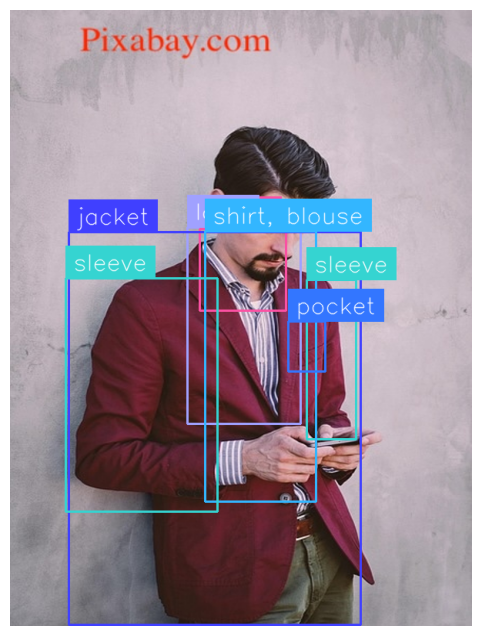

In [29]:
boxes_xyxy = torchvision.ops.box_convert(
    filtered_boxes,
    in_fmt="cxcywh",
    out_fmt="xyxy"
)
boxes_xyxy[:, [0, 2]] *= image.width
boxes_xyxy[:, [1, 3]] *= image.height
predictions = {
    "boxes": boxes_xyxy.cpu().numpy(),
    "labels": [CATS[label.item()] for label in filtered_labels],
    "scores": filtered_scores.cpu().numpy()
}

annotated_image = visualize_bboxes(
    np.array(image), predictions, show_scores=False
)

plt.figure(figsize=(8, 8))
plt.imshow(annotated_image)
plt.axis("off")
plt.show()